In [1]:
!pip install pytorch-lightning torch lightning fabric


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import lightning.pytorch as pl
from torch.utils.data import DataLoader
import os
import numpy as np
import torch
import lightning as L
from lightning import Fabric as f
import torch.nn as nn
from dataclasses import dataclass
from torch.nn import functional as F
import math

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.2 MB/s eta 0:00:00


In [6]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")



In [7]:
block_size = 8


In [8]:
config = {k:v for k,v in globals().items() if not k.startswith("_") and isinstance(v,(int,float,bool,str))}


In [9]:
class Config(dict):
  def __init__(self,config):
    self.__dict__.update(config)
    

In [10]:
config = Config(config)

In [11]:
config.block_size

8

In [12]:
class NextToken(torch.utils.data.Dataset):##custom daatset
  def __init__(self,bin_file,config):
    super().__init__()
    self.data = np.memmap(bin_file,dtype=np.uint16,mode='r')#memmap
    self.config = config
  
  def __len__(self):
    return (len(self.data) - self.config.block_size)

  def __getitem__(self,i):
    data = self.data
    start_index = i
    end_index = start_index + self.config.block_size
    x = torch.from_numpy((self.data[start_index:end_index]).astype(np.int64))
    y = torch.from_numpy((self.data[start_index + 1:end_index + 1]).astype(np.int64))
    return x, y

In [13]:
from torch.utils.data.distributed import DistributedSampler
class Sampler(DistributedSampler):
  def __init__(self,dataset,world_size,rank,shuffle):
    super().__init__(dataset=dataset,num_replicas=world_size,rank=rank,shuffle=shuffle)



In [15]:
class DataModule(pl.LightningDataModule):
  def __init__(self,dir_path,config,trainer):
    self.dir_path = dir_path
    self.prepare_data_per_node = True
    self.config = config
    self.trainer = trainer
  
  def prepare_data(self):
    input_file_path = os.path.join(self.dir_path,"input.txt")

    with open(input_file_path,'r') as f:
      text = f.read()
    n = len(text)

    train_data = text[:int(n*0.9)]
    val_data = text[int(n*0.9):]
    #encode
    train_ids = enc.encode_ordinary(train_data)
    val_ids = enc.encode_ordinary(val_data)
    #print
    if self.trainer.is_global_zero:
      print(f"train_ids has {len(train_ids)} tokens")
      print(f"val_ids has {len(val_ids)} tokens")
    #convert to numpy
    train_ids = np.array(train_ids, dtype=np.uint16)
    val_ids = np.array(val_ids, dtype=np.uint16)
    #export_to_file
    train_ids.tofile(os.path.join(self.dir_path,'train.bin'))
    val_ids.tofile(os.path.join(self.dir_path,'val.bin'))

  def setup(self, stage):
    if stage == "fit":
      self.train_data = NextToken(bin_file=os.path.join(self.dir_path, "train.bin"), config=self.config)#train_dataset = torch.utild.dataset(nextTokendataset)
      if self.trainer.is_global_zero:
        self.val_data = NextToken(bin_file=os.path.join(self.dir_path, "val.bin"), config=self.config)
    
    if stage == "predict":
      self.predict_data = NextToken(bin_file=os.path.join(self.dir_path, "predict.bin"), config=self.config)

  def train_dataloader(self):
    sampler = Sampler(dataset=self.train_data,world_size=self.trainer.world_size, rank=self.trainer.local_rank, shuffle=False)
    return DataLoader(self.train_data, batch_size=64, pin_memory=False, num_workers=0, sampler=sampler)  
  
  def val_dataloader(self):
    if self.trainer.is_global_zero:
      return DataLoader(self.val_data, batch_size=64, pin_memory=False, num_workers=0)
    else:
      print("only master node have val_data")
      return None


In [45]:
trainer = pl.Trainer(accelerator="cuda",max_epochs=10,use_distributed_sampler=False)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
dm  = DataModule("/content/data",config=config,trainer=trainer)

In [22]:
dm.prepare_data()

train_ids has 18498 tokens
val_ids has 2172 tokens


In [23]:
dm.setup(stage="fit")

In [24]:
dt = dm.train_dataloader()

In [25]:
#########MODEL#####################

In [26]:
class CausalSelfAttention(nn.Module):
  def __init__(self,config):
    super().__init__()
    assert config.n_embd & config.n_head == 0
    self.c_attn = nn.Linear(config.n_embd,3*config.n_embd,bias=config.bias)
    self.c_proj = nn.Linear(config.n_embd,config.n_embd,bias=config.bias)
    self.attn_dropout = nn.Dropout(config.dropout)
    self.resid_dropout = nn.Dropout(config.dropout)

    self.n_head = config.n_head
    self.n_embd = config.n_embd
    self.dropout = config.dropout

  def forward(self,x):#B,T,C
    B,T,C = x.size()
    q,k,v = self.c_attn(x).split(self.n_embd,dim=2)
    q = q.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
    k = k.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
    v = v.view(B,T,self.n_head,C//self.n_head).transpose(1,2)#B T nh headDim->b nh t hs

    y = torch.nn.functional.scaled_dot_product_attention(q,k,v,attn_mask=None,dropout_p=self.dropout if self.training else 0,is_causal=True) #B NH T HS
    y = y.transpose(1,2).contiguous().view(B,T,C)

    out = self.c_proj(y)
    out = self.resid_dropout(y)
    return out #b  t c

#@title
class MLP(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.c_fc   = nn.Linear(config.n_embd, 4 * config.n_embd,bias=config.bias)
    self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd,bias=config.bias)
    self.dropout= nn.Dropout(config.dropout)
    self.act = nn.GELU()
  def forward(self,x):
    x = self.dropout(self.c_proj(self.act(self.c_fc(x))))
    return x

#@title
class Block(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.attn = CausalSelfAttention(config)
    self.ln_1 = LayerNorm(config.n_embd,config.bias)
    self.ln_2 = LayerNorm(config.n_embd,config.bias)
    self.mlp = MLP(config) # layernorm 2 a attention a mlp
  
  def forward(self,x):
    x = x + self.attn(self.ln_1(x))
    x = x + self.mlp(self.ln_2(x))
    return x

class LayerNorm(nn.Module):
  def __init__(self,ndim,bias):
    super().__init__()
    self.weight = nn.Parameter(torch.ones(ndim))
    self.bias =nn.Parameter(torch.zeros(ndim)) if bias else False
  
  def forward(self,x):
    return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)
  

In [39]:
class plModel(pl.LightningModule):
  def __init__(self,config):
    super().__init__()
    self.losslist = []
    self.config = config
    print(f"this model is on {self.device}")
    self.transformer = nn.ModuleDict(dict(
        wte = nn.Embedding(config.vocab_size,config.n_embd),
        wpe = nn.Embedding(config.block_size,config.n_embd),
        h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
        drop = nn.Dropout(config.dropout),
        ln_f = LayerNorm(config.n_embd,config.bias)
    ))
    self.lm_head = nn.Linear(config.n_embd,config.vocab_size,bias=False)

    self.apply(self._init_weights)

    for a,b in self.named_parameters():
      if a.endswith("c_proj.weight"):
        torch.nn.init.normal_(b,mean=0.0,std=0.02/math.sqrt(2 * config.n_layer))
  
    print(sum(p.numel() for p in self.parameters()))

  def _init_weights(self,module):
    if isinstance(module,nn.Linear):
      torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias)
    if isinstance(module,nn.Embedding):
      torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)
    
    
  def forward(self,x):#X=[B,CONTEXT_SIZE] = B,T
    b,t = x.size()
    pos = torch.arange(0,t,dtype=torch.int32, device=self.device).unsqueeze(0)
    t_emb = self.transformer.wte(x)
    #B,CONTEXT_SIZE,VOCAB_SIZE = B,T,C
    p_emb = self.transformer.wpe(pos)
    x = self.transformer.drop(t_emb+p_emb)
    for block in self.transformer.h:
      x = block(x) # b t c
    out = self.transformer.ln_f(x)###BTC WE HAVE TO PASS THRROUGH LM_HEAD FOR B T VOCAB_SIZE
    logits = self.lm_head(out)
    return logits
  
  def training_step(self,batch,batch_idx):
    x,y = batch
    x = x.to(self.device)
    y = y.to(self.device)
    logits = self(x)#b t vocab_dim
    B,T,vdim = logits.shape

    logits = logits.view(B*T,vdim)
    target = y.view(B*T)
    loss = F.cross_entropy(logits,target)
    self.losslist.append(loss)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(),lr=0.02)

  @torch.no_grad()
  def generate(self):
    pass
  

In [40]:
from dataclasses import dataclass
scale = 6
@dataclass
class ModelConfig:
  block_size:int=1024
  vocab_size:int=50304
  n_layer:int=12//scale
  n_embd:int=768//scale
  n_head:int=12//scale
  dropout:float=0.0
  bias:bool=True

In [41]:
model = plModel(ModelConfig)
model.device

this model is on cpu
13405696


device(type='cpu')

In [42]:
#trainer = pl.Trainer(use_distributed_sampler=False,max_epochs=1)

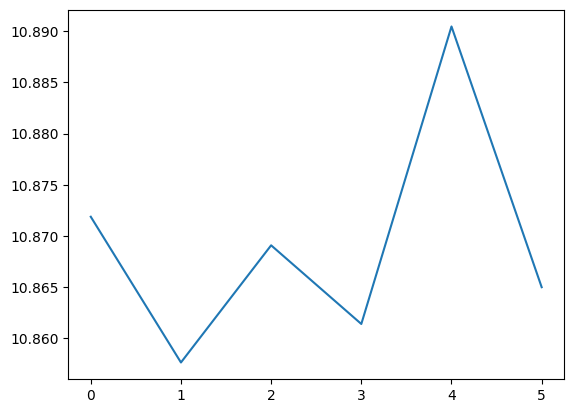

In [43]:
l = []
i = 0
for x,y in dt:
  loss =  model.training_step((x,y),i)
  i+=1
  l.append(loss.item())
  if i>5:
    break
import matplotlib.pyplot as plt
plt.plot(l)



In [44]:
for a,b in dt:
  x=a
  y=b
  print(x.dtype,x.shape)
  break

torch.int64 torch.Size([64, 8])


In [46]:
trainer.fit(model,train_dataloaders=dt)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type       | Params
-------------------------------------------
0 | transformer | ModuleDict | 7.0 M 
1 | lm_head     | Linear     | 6.4 M 
-------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.623    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | transformer | ModuleDict | 7.0 M 
1 | lm_head     | Linear     | 6.4 M 
-------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.623    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [52]:
model.losslist[0]>model.losslist[-1]

tensor(True, device='cuda:0')

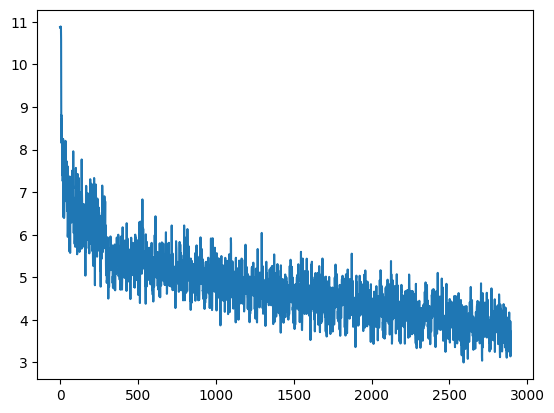

In [49]:
out = []
for it in model.losslist:
  out.append(it.item())
#out.reverse()
plt.plot(out)